<a href="https://colab.research.google.com/github/CallumCoffey/ANN/blob/main/4_2_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative Adversarial Networks (GANs)
======================================
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder. If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [ ]:
import sys

In [ ]:
# install pytorch (http://pytorch.org/) and tqdm if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision #--index-url https://download.pytorch.org/whl/cu118  #uncomment to enforce cuda 11.8
if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm

%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

print(f"Using Pytorch {torch.__version__}.")

Using Pytorch 2.3.0+cu121.


Parameter Settings
-------------------


In [ ]:
latent_dim = 10       # latent dimension
num_epochs = 50       # number of training epochs
batch_size = 512      # batch size (you may increase it to gain time, but check not to
                      # exceed your GPU memory limit)
learning_rate = 0.001  # learning rate of the training algorithm
use_gpu = True        # use the GPU (strongly recommended for speed)
compile = False       # not well implemented on Colab (requires a personal installation with a
                      # relatively recent CUDA-compatible GPU)

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.ToTensor()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

mnist_dims = train_dataloader.dataset[0][0].shape[1:]
mnist_dim = train_dataloader.dataset[0][0].numel()

Vanilla GAN
-----------
We define here the architecture of the different elements of the model. The init defines the different layers and the forward defines what happens when the model is called. We refer to it as the vanilla GAN as it the model in a very simple form.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, mnist_dim)
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = F.tanh(self.fc4(x))
        return x.view(-1, *mnist_dims)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(mnist_dim, 32)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

    def get_intermediate_features(self, x):
        """
        Compute and return intermediate features from specific layers of the discriminator.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tuple: Tuple containing intermediate features from different layers.
        """
        x = x.flatten(start_dim=1)
        features = []
        # Pass through layers and store intermediate activations
        x = F.leaky_relu(self.fc1(x), 0.2)
        # features.append(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        features.append(x)
        # x = F.leaky_relu(self.fc3(x), 0.2)
        # features.append(x)
        return features

Training
--------
Be careful, the training can be relatively long, even with a GPU on Colab.

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import grad
import torch

generator = Generator()
discriminator = Discriminator()

if compile:
  generator = torch.compile(generator)
  discriminator = torch.compile(discriminator)
  print("Using a compiled model (faster).")

if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.

# gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
# disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# i added lr scheduler
gen_scheduler = ReduceLROnPlateau(gen_optimizer, mode='min', factor=0.1, patience=5, verbose=True)
disc_scheduler = ReduceLROnPlateau(disc_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    real_correct = 0
    fake_correct = 0
    total_samples = 0

    if epoch % 10 == 0:
      generator.eval()

      # sample two latent vectors from the standard normal distribution
      latent_1 = torch.randn(1, latent_dim, device=device)
      latent_2 = torch.randn(1, latent_dim, device=device)

      # interpolation lambdas
      lambda_range=np.linspace(0,1,5)

      fig, axs = plt.subplots(1,5, figsize=(15, 3))
      fig.subplots_adjust(wspace=.1)
      axs = axs.ravel()

      for ind, l in enumerate(lambda_range):
          inter_image=interpolation(float(l), generator, latent_1, latent_2)

          image = inter_image.numpy()

          axs[ind].imshow(image[0,:,:].squeeze(), cmap='gray')
          axs[ind].set_title('$\lambda$='+str(round(l,1)))
          axs[ind].axis('off')
      plt.show()

    for image_batch, _ in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True):
        # moving the batch onto GPU if relevant
        image_batch = image_batch.to(device)

        # get dataset image and create real and fake labels for use in the loss
        # label_real = torch.ones(image_batch.size(0), device=device)
        # label_fake = torch.zeros(image_batch.size(0), device=device)

        label_real = torch.full((image_batch.size(0),), 0.9, device=device)
        # label_fake = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)



        # # # Generate noisy labels for the discriminator
        discriminator_label_real = label_real
        discriminator_label_fake = label_fake

        # # # Define the probability of flipping labels
        # flip_probability = 0.05  # Adjust this probability as needed
        # # Flip labels occasionally
        # for i in range(len(label_real)):
        #     if random.random() < flip_probability:
        #         discriminator_label_real[i] = 1.0 - discriminator_label_real[i]
        #     if random.random() < flip_probability:
        #         discriminator_label_fake[i] = 1.0 - discriminator_label_fake[i]

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dim, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        # real_pred = discriminator(image_batch).squeeze()
        # fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        # disc_loss = 0.5 * (
        #     F.binary_cross_entropy(real_pred, discriminator_label_real) +
        #     F.binary_cross_entropy(fake_pred, discriminator_label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # Calculate discriminator accuracy#------------------------------------------------
        real_correct += (real_pred >= 0.5).sum().item()
        fake_correct += (fake_pred < 0.5).sum().item()
        total_samples += image_batch.size(0)#------------------------------------------------


        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        # # Lambda feature matching: compute feature statistics on real and fake images-----------------------
        # real_features = discriminator.get_intermediate_features(image_batch.detach())
        # fake_features = discriminator.get_intermediate_features(fake_image_batch.detach())

        # # Concatenate intermediate features tensors
        # real_features = torch.cat(real_features, dim=1)
        # fake_features = torch.cat(fake_features, dim=1)

        # # Compute mean squared error between feature statistics
        # feature_matching_loss = F.mse_loss(real_features, fake_features)

        # # Combine generator loss with feature matching loss using a lambda coefficient
        # lambda_fm = 1  # Adjust this coefficient as needed
        # gen_loss += lambda_fm * feature_matching_loss#-------------------------------------------------

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        if False:
            fake_image_batch = generator(latent)
            fake_pred = discriminator(fake_image_batch).squeeze()
            gen_loss = F.binary_cross_entropy(fake_pred, label_real)

            real_features = discriminator.get_intermediate_features(image_batch.detach())
            fake_features = discriminator.get_intermediate_features(fake_image_batch.detach())
            real_features = torch.cat(real_features, dim=1)
            fake_features = torch.cat(fake_features, dim=1)
            feature_matching_loss = F.mse_loss(real_features, fake_features)
            lambda_fm = 1
            gen_loss += lambda_fm * feature_matching_loss

            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

        real_accuracy = real_correct / total_samples#------------------------------------------------
        fake_accuracy = fake_correct / total_samples
        overall_accuracy = (real_correct + fake_correct) / (2 * total_samples)#------------------------------------------------

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches

    #adjust lr#------------------------------------------------
    # gen_scheduler.step(gen_loss_avg[-1])
    # disc_scheduler.step(disc_loss_avg[-1])#------------------------------------------------

    print(f"\tAverage loss generator vs. discrim.: {gen_loss_avg[-1]:.3} vs. {disc_loss_avg[-1]:.3}")

    print(f"\tDiscriminator real accuracy: {real_accuracy:.2%}, fake accuracy: {fake_accuracy:.2%}, overall accuracy: {overall_accuracy:.2%}")

print("Done.")

Using the GPU (faster).
Number of parameters for generator: 13715216 and discriminator: 25793
Training...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


NameError: name 'np' is not defined

You may save the obtained weights after training.

In [ ]:
import os
if not os.path.exists('./pretrained'):
  os.mkdir('./pretrained')

torch.save(generator.state_dict(), './pretrained/my_vanilla_gan_generator.pth')
torch.save(discriminator.state_dict(), './pretrained/my_vanilla_gan_discriminator.pth')

If already saved, they can be loaded in the following way.

In [ ]:
# first load your model to generate instances of the generator and discriminator (but don't train it)
generator.load_state_dict(torch.load('./pretrained/my_vanilla_gan_generator.pth'))
discriminator.load_state_dict(torch.load('./pretrained/my_vanilla_gan_discriminator.pth'))

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "deconv1.weight", "deconv1.bias", "deconv1_bn.weight", "deconv1_bn.bias", "deconv1_bn.running_mean", "deconv1_bn.running_var", "deconv2.weight", "deconv2.bias", "deconv2_bn.weight", "deconv2_bn.bias", "deconv2_bn.running_mean", "deconv2_bn.running_var", "deconv3.weight", "deconv3.bias", "deconv3_bn.weight", "deconv3_bn.bias", "deconv3_bn.running_mean", "deconv3_bn.running_var", "deconv4.weight", "deconv4.bias". 
	Unexpected key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias", "fc4.weight", "fc4.bias". 

Training Curves
---------------

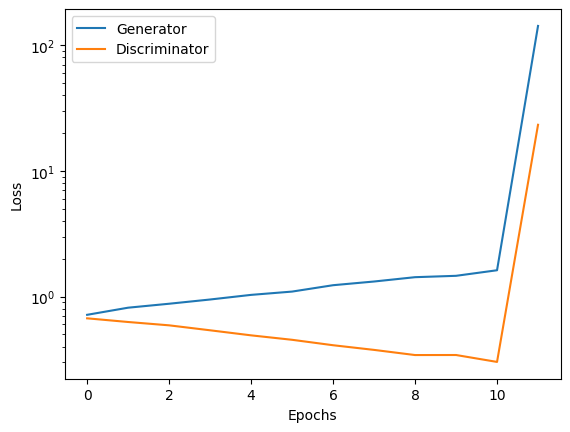

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.semilogy(gen_loss_avg, label='Generator')
plt.semilogy(disc_loss_avg, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Interpolate in Latent Space
----------------------------

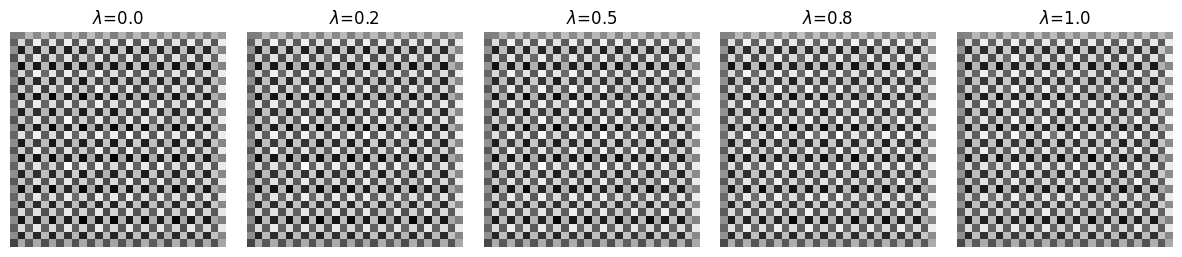

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dim, device=device)
latent_2 = torch.randn(1, latent_dim, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,:,:].squeeze(), cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

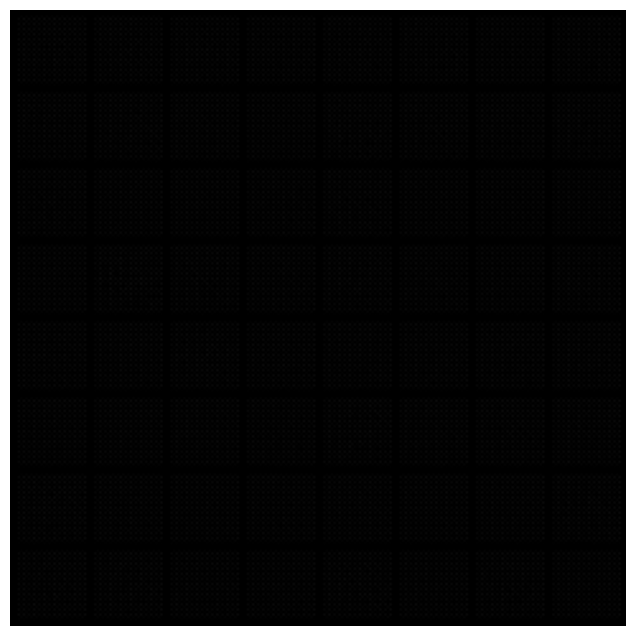

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn(n**2, latent_dim, device=device)
    fake_image_batch = generator(latent)
    if len(fake_image_batch.shape) == 3:
        fake_image_batch = fake_image_batch.unsqueeze(1)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

A CNN as Backbone
-----------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters. Running this will shadow the alternative vanilla version above. You will still need to instantiate it.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

Don't hesitate to tweak the architecture to improve it.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        dim1 = 32 #32
        dim2 = 16 #16
        self.deconv1 = nn.ConvTranspose2d(latent_dim, latent_dim * dim1, 5, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(latent_dim * dim1)
        self.deconv2 = nn.ConvTranspose2d(latent_dim * dim1, latent_dim * dim2, 5, 1, 1)
        self.deconv2_bn = nn.BatchNorm2d(latent_dim * dim2)
        self.deconv3 = nn.ConvTranspose2d(latent_dim * dim2, latent_dim, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(latent_dim)
        self.deconv4 = nn.ConvTranspose2d(latent_dim, 1, 4, 2, 1)

    def forward(self, x):
        x = x[:, :, None, None]
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        dim1 = 16 #16
        dim2 = 32 #32
        self.conv1 = nn.Conv2d(1, latent_dim, 4, 2, 1)
        self.conv1_bn = nn.BatchNorm2d(latent_dim)
        self.conv2 = nn.Conv2d(latent_dim, latent_dim * dim1, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(latent_dim * dim1)
        self.conv3 = nn.Conv2d(latent_dim * dim1, latent_dim * dim2, 5, 1, 1)
        self.conv3_bn = nn.BatchNorm2d(latent_dim * dim2)
        self.conv4 = nn.Conv2d(latent_dim * dim2, latent_dim, 5, 1, 0)
        self.conv4_bn = nn.BatchNorm2d(latent_dim)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(latent_dim, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1_bn(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.fc(self.flatten(x)))
        return x

Again, you can save and load the trained weights.

In [ ]:
torch.save(generator.state_dict(), './pretrained/my_cnn_gan_generator.pth')
torch.save(discriminator.state_dict(), './pretrained/my_cnn_gan_discriminator.pth')

In [ ]:
generator.load_state_dict(torch.load('./pretrained/my_cnn_gan_generator.pth'))
discriminator.load_state_dict(torch.load('./pretrained/my_cnn_gan_discriminator.pth'))

You can now have a look at the results of the model by running again the corresponding sections.

In [ ]:
# from google.colab import runtime
# runtime.unassign()